In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats
# Giannoulis, this is a test

            Timestamp      Wsp      TI  TI,detrend   MeanDir  MeanTrigDir  \
0 2004-10-01 00:00:00   9.9196  0.0181      0.0145  346.7130     346.7130   
1 2004-10-01 00:20:00   9.5073  0.0145      0.0116  346.9852     346.9852   
2 2004-10-01 00:30:00   9.5274  0.0210      0.0195  346.9152     346.9151   
3 2004-10-01 00:40:00   9.9498  0.0253      0.0195  346.3204     346.3204   
4 2004-10-01 00:50:00  10.2376  0.0151      0.0134  345.4185     345.4185   

   StdDir   MinDir   MaxDir  
0  0.8440  343.893  349.044  
1  0.6518  344.751  348.949  
2  0.7949  343.754  350.588  
3  0.7549  343.971  349.953  
4  0.6362  343.074  348.960  


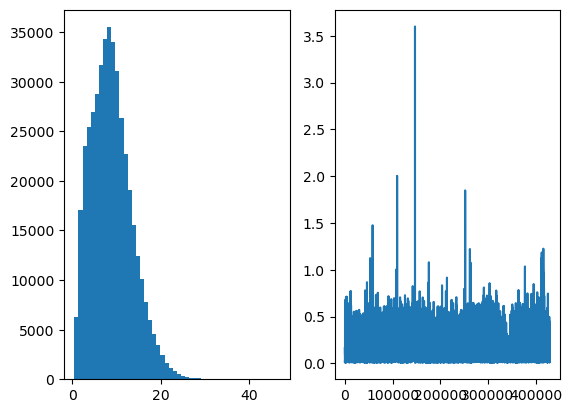

In [66]:
data_path = '../data/'
results_path = '../results/'

# load and print dataset
raw_data = pd.read_csv(data_path + 'HovsoreData_Sonic_100m_2004-2013.csv')
raw_data.head()
raw_data['Timestamp'] = pd.to_datetime(raw_data['Timestamp'], format='%Y%m%d%H%M')

filt_idx = ((raw_data["Wsp"] > 60) | (raw_data["Wsp"] < 0.05)) | ((raw_data["TI"] < 0.01) | (raw_data["TI"] > 4))
filtered_data = raw_data[~filt_idx]
filtered_data = filtered_data.dropna(axis=0)
filtered_data = filtered_data.reset_index(drop=True)
print(filtered_data.head(5))

# visualise dataset
# plt.plot(raw_data['Wsp'])
fig, ax = plt.subplots(1,2)
# ax[0].hist(raw_data["Wsp"][raw_data["Wsp"] < 60], 50)
# ax[1].plot(raw_data["TI"]) # outliers can be observed
ax[0].hist(filtered_data["Wsp"], 50)
ax[1].plot(filtered_data["TI"]) # outliers can be observed

plt.show()

# Fit joint distribution to wind speed, turbulence

In [38]:
# compute turbulence from sigmaU = TI * Wsp
filtered_data['sigmaWsp'] = filtered_data["TI"] * filtered_data["Wsp"]
filtered_data.head(3)

# fit weibull to wind speed : maximum likelihood method
Wsp0 = np.asarray(filtered_data["Wsp"])
# Wsp0 = Wsp0[Wsp0 < 60]
print(sum(np.isnan(Wsp0)))

mle_Weib = lambda theta : -np.sum(np.log( stats.weibull_min.pdf(Wsp0, loc=0, scale=theta[0], c=theta[1]) ))
Weibull_params = scipy.optimize.minimize(mle_Weib, [Wsp0.mean(), np.log(Wsp0).std()])
print(Weibull_params)
A_weibull = Weibull_params.x[0]
k_weibull = Weibull_params.x[1]

print("\nWeibull distribution:")
print(f"A:{A_weibull}")
print(f"k:{k_weibull}")

# fitted weibull distribution
Wsp_sort = np.sort(Wsp0)
pdf_weibull = stats.weibull_min.pdf(Wsp_sort, scale=A_weibull, c=k_weibull)

0
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1239279.5737238422
        x: [ 9.983e+00  2.033e+00]
      nit: 10
      jac: [ 0.000e+00  0.000e+00]
 hess_inv: [[ 1.294e-04  4.971e-05]
            [ 4.971e-05  2.598e-05]]
     nfev: 42
     njev: 14

Weibull distribution:
A:9.9834258809259
k:2.032556323671337


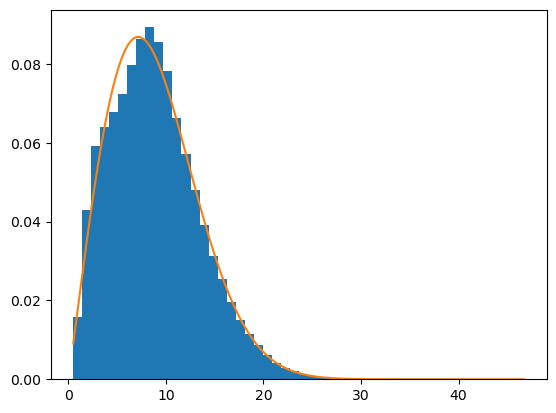

In [39]:
# Visualise fitted distribution
fig, ax = plt.subplots(1)
ax.hist(Wsp0, bins=50, density=True)
ax.plot(Wsp_sort, pdf_weibull)
plt.show()

In [41]:
# Fit conditional distribution to turbulence - bin data
WspBinEdges = np.arange(3.5, 32.5, 1)
WspBinCentres = .5 + WspBinEdges[:-1]

# initialise mean and std of turbulence for each bin
meanSigmaBinned = np.zeros_like(WspBinCentres)
stdSigmaBinned = np.zeros_like(WspBinCentres)

# find mean and std of turbulence (=sigmaU) in each bin
for i,val in enumerate(WspBinCentres):
    WspMask = (filtered_data["Wsp"] > WspBinEdges[i]) & (filtered_data["Wsp"] <= WspBinEdges[i+1])
    meanSigmaBinned[i] = np.mean( filtered_data.loc[WspMask, "sigmaWsp"] )
    stdSigmaBinned[i] = np.std( filtered_data.loc[WspMask, "sigmaWsp"] )
    
meanSigmaBinned = meanSigmaBinned[~np.isnan(meanSigmaBinned)]   
stdSigmaBinned = stdSigmaBinned[~np.isnan(meanSigmaBinned)]   
# print(len(WspBinEdges))
# print(enumerate(WspBinCentres))
# print(len(meanSigmaBinned))
# print(len(meanSigmaBinned))

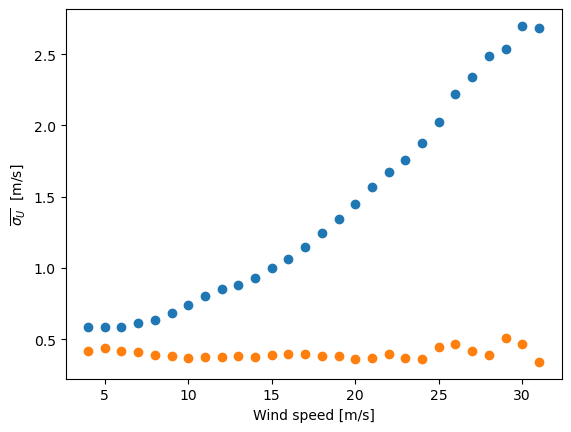

In [42]:
plt.scatter(WspBinCentres, meanSigmaBinned)
plt.scatter(WspBinCentres, stdSigmaBinned)
plt.xlabel("Wind speed [m/s]")
plt.ylabel(r"$\overline{\sigma_U}$  [m/s]")
plt.show()

In [47]:
pMu0 = np.polyfit(WspBinCentres, meanSigmaBinned,0)
pMu1 = np.polyfit(WspBinCentres, meanSigmaBinned,1)
pMu2 = np.polyfit(WspBinCentres, meanSigmaBinned,2)
pMsu0 = np.polyfit(WspBinCentres, stdSigmaBinned,0)

poly0 = np.poly1d(pMu0)
poly1 = np.poly1d(pMu1)
poly2 = np.poly1d(pMu2)
poly3 = np.poly1d(pMsu0)

SigmaSigmaRef = np.mean(stdSigmaBinned)
        
MuSigmaFunc = lambda u: poly2(u)
SigmaSigmaFunc = lambda u: SigmaSigmaRef * np.ones(u.shape)


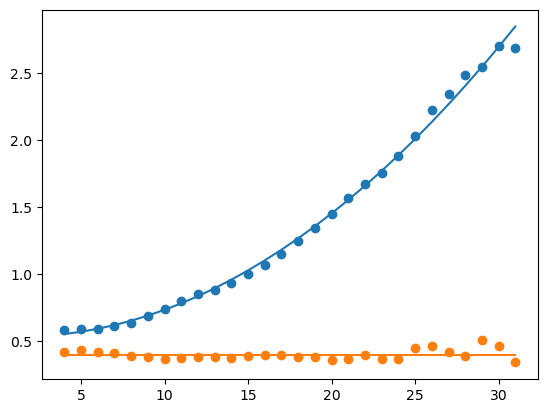

In [48]:
plt.scatter(WspBinCentres, meanSigmaBinned)
plt.scatter(WspBinCentres, stdSigmaBinned)
# plt.plot(WspBinCentres, poly0(WspBinCentres))
# plt.plot(WspBinCentres, poly1(WspBinCentres))
plt.plot(WspBinCentres, poly2(WspBinCentres))
plt.plot(WspBinCentres, poly3(WspBinCentres))
plt.show()

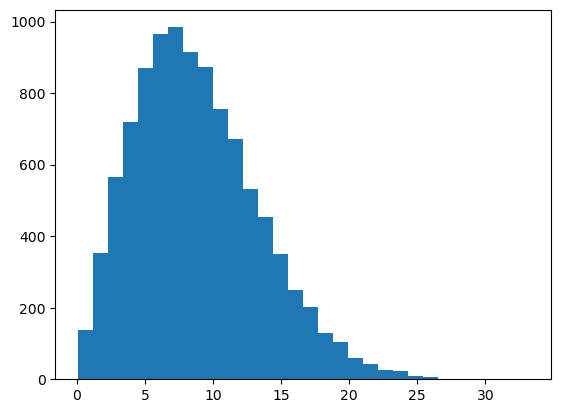

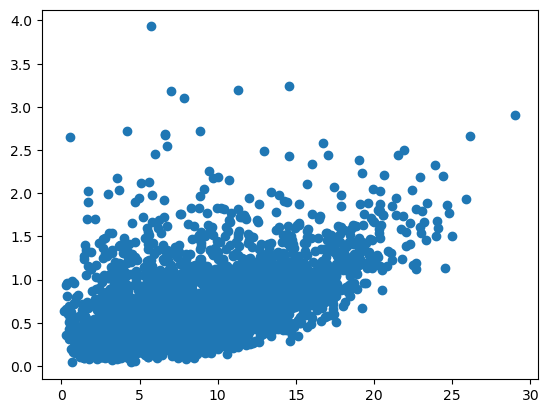

In [67]:
# Monte Carlo 
n = 10000

# Wind speed random sample
Urand = stats.weibull_min.ppf(np.random.randn(n), scale=A_weibull, c=k_weibull)
Urand = stats.weibull_min.rvs(scale=A_weibull, c=k_weibull, size=n)

# Turbulence random sample
def NormalDist(task,x,mu=0,sigma=1):
    import numpy as np
    if task == 0: # PDF
        y = (1.0/(sigma*np.sqrt(2.0*np.pi)))*np.exp(-((x - mu)**2)/(2.0*(sigma**2)))
    elif task == 1: # Cumulative
        from scipy.special import erf
        y = 0.5*(1.0 + erf((x - mu)/(sigma*np.sqrt(2))))
    elif task == 2: # Inverse
        from scipy.special import erfinv
        y = mu + sigma*np.sqrt(2)*erfinv(2*x - 1)        
    return y
# Helper function - lognormal distribution
def LogNormDist(task,x,mu,sigma):
    import numpy as np
    tol = 1e-16
    mu = np.asarray(mu)
    mu[mu<tol] = tol
    Eps   = np.sqrt(np.log( 1.0+(sigma/mu)**2 ) )
    Ksi   = np.log(mu)-0.5*Eps**2
    if task == 0: # PDF
        x[x<=0] = 1e-8
        u =(np.log(x)-Ksi)/Eps
        y = np.exp(-u*u/2.0)/(Eps*x*np.sqrt(2.0*np.pi))
    elif task == 1: # Cummulative
        x[x<=0] = 1e-8
        u =(np.log(x)-Ksi)/Eps
        y= NormalDist(1, u)
    elif task == 2: # Inverse
        y= np.exp(Ksi+Eps*NormalDist(2, x))
    
    return y

MuSigmaU = MuSigmaFunc(Urand)
SigmaSigmaU = SigmaSigmaFunc(Urand)
SigmaUrand = LogNormDist(2, np.random.randn(n), mu=MuSigmaU, sigma=SigmaSigmaU)
# SigmaSigmaUrand = stats.lognorm.ppf(np.random.randn(n), s=SigmaSigmaU)

plt.hist(Urand, 30)
plt.show()
plt.scatter(Urand, SigmaUrand)
plt.show()

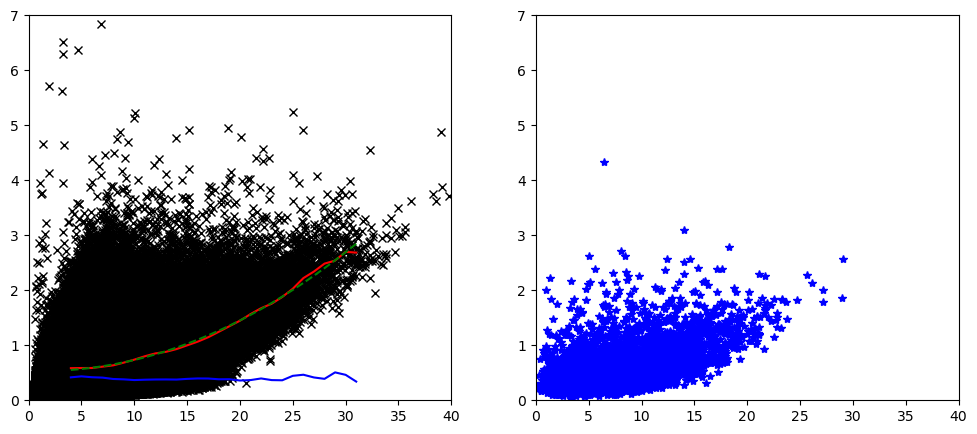

In [51]:
fig,ax = plt.subplots(1,2, figsize = (12,5))
ax[0].plot(filtered_data['Wsp'],filtered_data['sigmaWsp'],'xk')
ax[0].plot(WspBinCentres,meanSigmaBinned,'-r')
ax[0].plot(WspBinCentres,stdSigmaBinned,'-b')
ax[0].plot(WspBinCentres,MuSigmaFunc(WspBinCentres),'--g')
ax[0].set_xlim([0,40])
ax[0].set_ylim([0,7])
ax[1].plot(Urand,SigmaUrand,'*b')
ax[1].set_xlim([0,40])
ax[1].set_ylim([0,7])
plt.show()

# Task 2

In [176]:
yearss = pd.unique(filtered_data['Timestamp'].dt.year.values)

BootstrapMeans = np.zeros_like(filtered_data['Wsp'])
x_temp = 0
for i in range(len(yearss)):
    boot2004 = filtered_data[filtered_data['Timestamp'].dt.year == yearss[i]]

    alpha = 1 - 0.95

    Nbootstrap = len(boot2004)
    BootstrapSize = 10

    BootstrapSample = np.random.choice(boot2004['Wsp'], size = (Nbootstrap,BootstrapSize))

    BootstrapMeans[x_temp:x_temp+Nbootstrap] = np.sort(np.mean(BootstrapSample, axis=1))

    
    Rlow = int(np.around(alpha/2*(Nbootstrap+1)))
    Rhigh = int(np.around((1-alpha/2)*(Nbootstrap+1)))
#     print(x_temp+Rlow,x_temp+Rhigh)

#     print(Rlow,Rhigh)
    CIn_B = BootstrapMeans[x_temp+Rlow]
    CIp_B = BootstrapMeans[x_temp+Rhigh]
    
    x_temp = x_temp + Nbootstrap
    
#     print(Nbootstrap)
#     print(x_temp)
#     print()
    print(yearss[i])
    print('Confidence interval based on bootstrapping: [' + str(CIn_B) + ', ' + str(CIp_B) + ']')

BootstrapMeans = np.sort(BootstrapMeans)
print(np.mean(BootstrapMeans))

2004
Confidence interval based on bootstrapping: [7.0903599999999996, 13.31144]
2005
Confidence interval based on bootstrapping: [6.18397, 11.59965]
2006
Confidence interval based on bootstrapping: [5.85985, 11.23266]
2007
Confidence interval based on bootstrapping: [6.48768, 12.79552]
2008
Confidence interval based on bootstrapping: [6.4000900000000005, 12.18998]
2009
Confidence interval based on bootstrapping: [5.934279999999999, 11.300410000000001]
2010
Confidence interval based on bootstrapping: [5.8011, 11.01336]
2011
Confidence interval based on bootstrapping: [6.5380899999999995, 12.4665]
2012
Confidence interval based on bootstrapping: [6.412470000000001, 12.02761]
2013
Confidence interval based on bootstrapping: [5.21375, 10.34629]
8.841560721997801


In [276]:
yearss = pd.unique(filtered_data['Timestamp'].dt.year.values)
# yearss = pd.unique(filtered_data['Timestamp'].dt.month.values)
# yearss = yearss[range(3)]
print(yearss)

BootstrapMeans = np.zeros_like(filtered_data['Wsp'])
Umean = np.mean(filtered_data['Wsp'])
Ustd = np.std(filtered_data['Wsp'])
n = len(filtered_data['Wsp'])
print(n)

[2004 2005 2006 2007 2008 2009 2010 2011 2012 2013]
429752


In [279]:
BootstrapMeans = []
for i in range(len(yearss)):
    
    boot2004 = filtered_data[filtered_data['Timestamp'].dt.year == yearss[i]]
#     boot2004 = filtered_data[filtered_data['Timestamp'].dt.month == yearss[i]]

    alpha = 1 - 0.92

    Nbootstrap = len(boot2004)
    BootstrapSize = 100

    BootstrapSample = np.random.choice(boot2004['Wsp'], size = (Nbootstrap,BootstrapSize))

#     BootstrapMeans[x_temp:x_temp+Nbootstrap] = np.sort(np.mean(BootstrapSample, axis=1))
    BootstrapMeans = np.append(BootstrapMeans, np.sort(np.mean(BootstrapSample, axis=1)))
    
#     x_temp = x_temp + Nbootstrap

BootstrapMeans = np.sort(BootstrapMeans)
print(np.mean(BootstrapMeans))

M = len(BootstrapMeans)
Rlow = int(np.around(alpha/2*(M+1)))
Rhigh = int(np.around((1-alpha/2)*(M+1)))

#     print(Rlow,Rhigh)
CIn_B = BootstrapMeans[Rlow]
CIp_B = BootstrapMeans[Rhigh]
    
# #     print(Nbootstrap)
# #     print(x_temp)
# #     print()
print('Confidence interval based on bootstrapping: [' + str(CIn_B) + ', ' + str(CIp_B) + ']')

CIn_N = Umean + stats.norm.ppf(alpha/2) * Ustd / np.sqrt(n)
CIp_N = Umean + stats.norm.ppf(1 - alpha/2) * Ustd / np.sqrt(n)

print('Confidence interval based on the Normal distribution: [' + str(CIn_N) + ', ' + str(CIp_N) + ']')
# BootstrapMeans = np.sort(BootstrapMeans)
# print(np.mean(BootstrapMeans))

8.840175805869432
Confidence interval based on bootstrapping: [7.589766, 10.089892000000003]
Confidence interval based on the Normal distribution: [8.827985212174893, 8.852374745195826]


In [ ]:
Confidence interval based on bootstrapping: [7.6685430000000006, 10.015604] 90
Confidence interval based on bootstrapping: [7.056976, 10.688058999999999] 99


0.0069657071651594744


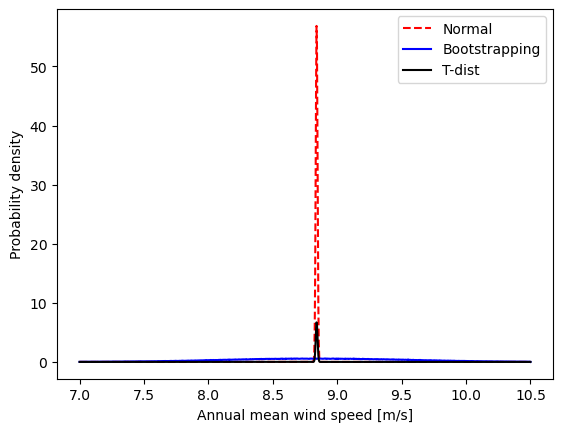

In [281]:
Ubins = np.linspace(7,10.5,1000)

print(Ustd/np.sqrt(n))
pdf_N = stats.norm.pdf(Ubins,Umean,Ustd/np.sqrt(n)) # Ustd/np.sqrt(n)
dU = Ubins[1]-Ubins[0] # Scaling factor for the t-pdf to make sure we get a valid pdf for every bin spacing
pdf_T = (1/np.sqrt(dU))*stats.t.pdf((Ubins - Umean)/(Ustd/np.sqrt(n)), n - 1)

# Generating an empirical pdf from the bootstrap sample
BootstrapHist = np.histogram(BootstrapMeans,bins = Ubins)
BootstrapDist = stats.rv_histogram(BootstrapHist)
pdf_B = BootstrapDist.pdf(Ubins)

fig1, ax1 = plt.subplots()
p11 = ax1.plot(Ubins,pdf_N,'--r', label = 'Normal')
p12 = ax1.plot(Ubins,pdf_B,'-b', label = 'Bootstrapping')
p13 = ax1.plot(Ubins,pdf_T,'-k', label = 'T-dist')
plt.xlabel('Annual mean wind speed [m/s]')
plt.ylabel('Probability density')
plt.legend()

plt.show()